# Tree Linearization on the XOR dataset

Some probes implemented in mislabeled rely on the assumption that the input estimator
is a linear model, to get explicit formulation for their derivatives with respect to
the input or coefficients.

In order to use these probes for model which are not linear (such as trees or MLPs),
we linearize them.

- for trees and ensembles, we train a surrogate linear model on the supervised kernel
  defined from the leaf indices where the input exemple falls in.
- for MLPs, the last hidden layer output features defines a supervised kernel,
  and the coefficients from the classification layer are used as a linear model.
- for linear models, this is a no-op.

In this notebook, we compute the self-influence of training data points for
different model families on a non-linearly separable dataset (XOR).


In [1]:
import numpy as np
from joblib import delayed, Parallel
from matplotlib import pyplot as plt
from scipy.stats import spearmanr
from sklearn.datasets import make_blobs
from sklearn.discriminant_analysis import StandardScaler
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.model_selection import LeaveOneOut
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.inspection import DecisionBoundaryDisplay


from mislabeled.probe import SelfInfluence

In [2]:
class TreeKernel:
    def __init__(self, estimator):
        self.estimator = estimator

    def fit(self, X, y):
        self.estimator_ = self.estimator.fit(X, y)
        self.encoder_ = OneHotEncoder(handle_unknown="ignore").fit(self.estimator_.apply(X).reshape(X.shape[0], -1))
        return self
    
    def transform(self, X):
        return self.encoder_.transform(self.estimator_.apply(X).reshape(X.shape[0], -1))

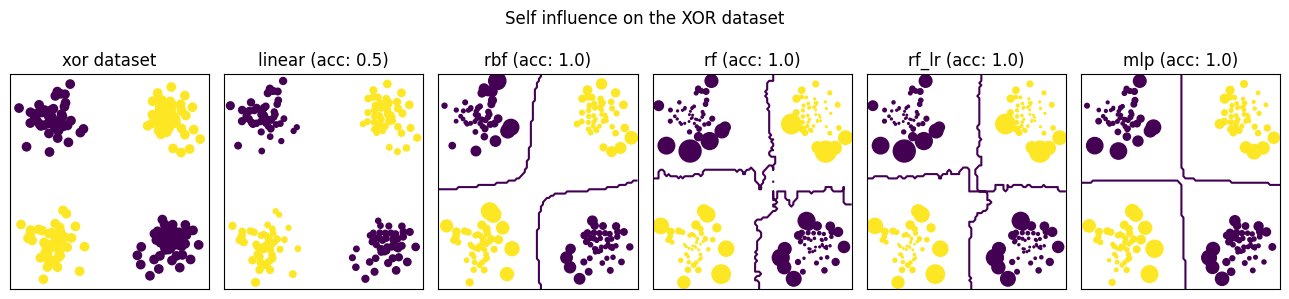

In [ ]:
X1, _ = make_blobs(centers=2, random_state=1)
X1 = StandardScaler().fit_transform(X1)
X = np.vstack((X1, X1 @ np.array([[0, -1], [1, 0]])))
y = np.hstack((np.ones(X1.shape[0]), np.zeros(X1.shape[0]))).astype(int)

models = dict(
    linear=LogisticRegression(random_state=1),
    rbf=make_pipeline(RBFSampler(random_state=1), LogisticRegression(random_state=1)),
    rf=(rf := ExtraTreesClassifier(max_depth=5, max_features=1, random_state=1)),
    rf_lr=make_pipeline(TreeKernel(rf), LogisticRegression(random_state=1)),
    mlp=MLPClassifier(solver="sgd", max_iter=2000, random_state=1),
)
probe = SelfInfluence()

probes = dict()

fig, ax = plt.subplots(1, len(models) + 1, figsize=(13, 3))


ax[0].scatter(X[:, 0], X[:, 1], c=y)
ax[0].set_xticks(())
ax[0].set_yticks(())
ax[0].set_title("xor dataset")

for i, (name, model) in enumerate(models.items()):
    model.fit(X, y)
    score = model.score(X, y)
    probes[name] = probe(model, X, y)

    ax[i + 1].scatter(
        X[:, 0], X[:, 1], c=y, s=20 * probes[name] / np.mean(probes[name])
    )
    ax[i + 1].set_xticks(())
    ax[i + 1].set_yticks(())
    ax[i + 1].set_title(f"{name} (acc: {score})")

    DecisionBoundaryDisplay.from_estimator(model, X, eps=0.1, ax=ax[i+1], plot_method="contour", response_method="predict", levels=[0])

fig.suptitle("Self influence on the XOR dataset")
plt.tight_layout()
plt.show()

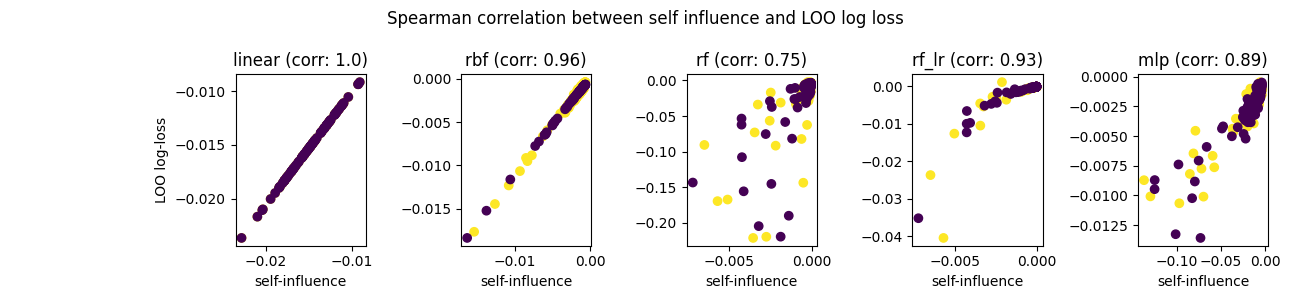

In [25]:
from sklearn import clone


fig, ax = plt.subplots(1, len(models) + 1, figsize=(13, 3))

ax[0].axis("off")
ax[1].set_ylabel("LOO log-loss")

for i, (name, model) in enumerate(models.items()):

    model.fit(X, y)

    def eval(model, X, y, train, test):

        loo_ll_diff = log_loss(
            y[test],
            model.predict_proba(X[test]),
            labels=np.unique(y),
        ) - log_loss(
            y[test],
            clone(model).fit(X[train], y[train]).predict_proba(X[test]),
            labels=np.unique(y),
        )
        return loo_ll_diff
    
    loo_ll_diff = Parallel(n_jobs=-1)(
        delayed(eval)(model, X, y, train, test) for train, test in LeaveOneOut().split(X)
    )

    corr = spearmanr(probes[name], loo_ll_diff).statistic
    ax[i + 1].scatter(probes[name], loo_ll_diff, c=y)
    # min = np.min([ax[i + 1].get_xlim(), ax[i + 1].get_ylim()])
    # max = np.max([ax[i + 1].get_xlim(), ax[i + 1].get_ylim()])
    # ax[i + 1].set_xlim((min, max))
    # ax[i + 1].set_ylim((min, max))
    # ax[i + 1].axline((min, min), (max, max), color="black")
    ax[i + 1].set_xlabel("self-influence")
    ax[i + 1].set_title(f"{name} (corr: {round(corr,2)})")

fig.suptitle("Spearman correlation between self influence and LOO log loss")
plt.tight_layout()
plt.show()